# Question 1

By refering to zenodo (https://zenodo.org/record/3685331#.ZE9O7uxBxUI), I think Cb-ord-A2-ff-1c-R100d means:
*   "Cb" refers to a contrabass instrument.
*   "ord" refers to ordinario playing technique.
*   "A2" refers to the pitch played, which is an A note in the second octave (approximately 110 Hz).
*   "ff" refers to the dynamics of the sound, which is fortissimo (very loud).
*   "1c" refers to the string used to produce the sound, which is likely the first string of the contrabass.
*   "R100d" means that the sound was resampled from a higher pitch and lowered by a semitone or 100 cents, and the letter "d" indicates that the pitch was lowered (i.e., "down").


# Package installation & setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Data_Colab/MIR')

Mounted at /content/drive/


In [2]:
!pip install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100718 sha256=4d370f9b128e42aad4ab95f0ec39786ab9c1bcec8a016190811783bc07a1e340
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [3]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import soundfile as sf
from math import sin, cos, radians
from itertools import repeat
import pandas as pd
import pickle
import mir_eval
import scipy.linalg
from typing import List
from scipy.stats import zscore
import numpy as np
from dataclasses import dataclass
# import librosa.display

In [4]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Question 2

In [ ]:
# load the example audio file (5 seconds, 22050 Hz)
filename = librosa.example('nutcracker')
y, sr = librosa.load(filename, sr=22050, duration=10)

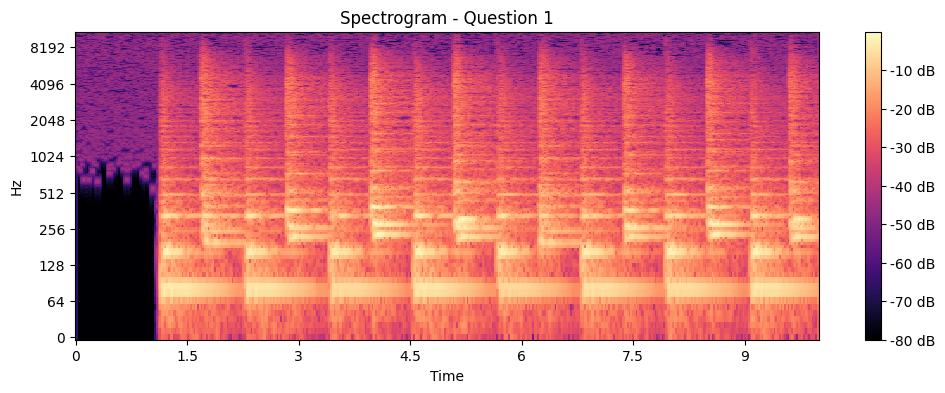

In [ ]:
D = librosa.power_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

[Text(0.5, 1.0, 'Mel-spectrogram')]

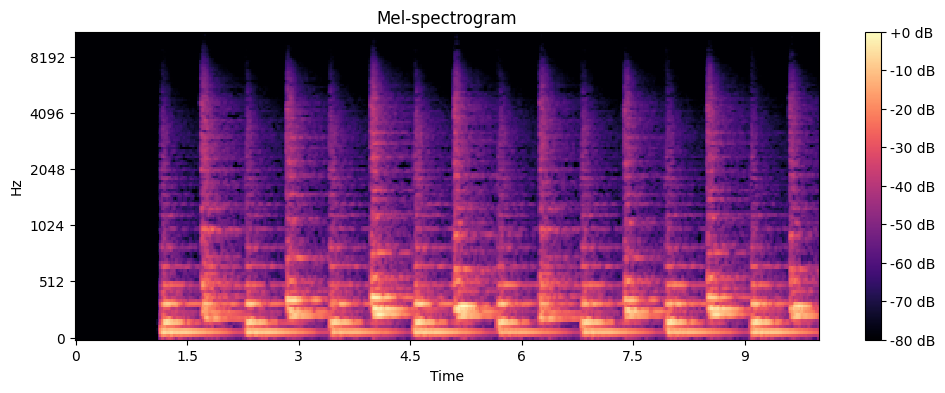

In [ ]:
# compute and plot the mel-spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-spectrogram')

[Text(0.5, 1.0, 'MFCC')]

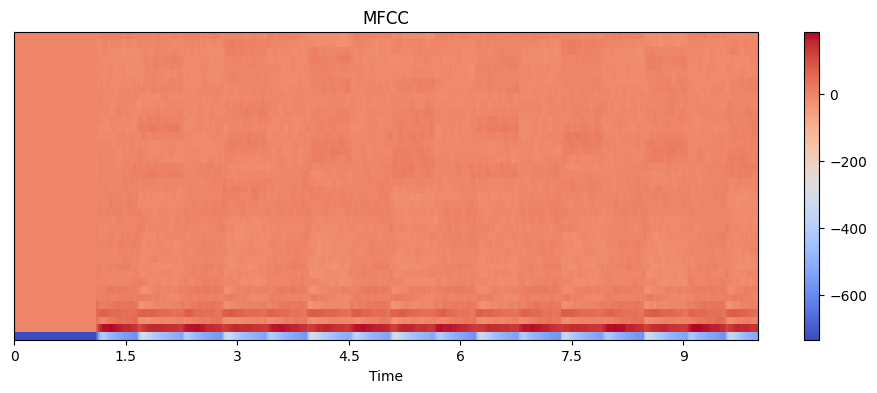

In [ ]:
# compute and plot the MFCC
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print(mfcc)
fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(img, ax=ax)
ax.set(title='MFCC')

Spectrogram: A spectrogram is a visual representation of the frequencies present in an audio signal over time. It is created by applying a short-time Fourier transform (STFT) to the signal. Spectrograms are sensitive to variations in overall amplitude and can include noise and other irrelevant features.

Mel-spectrogram: A mel-spectrogram has been transformed to better match the way humans perceive sound. This is achieved by mapping the linear frequency scale of the spectrogram to a mel-scale.The resulting mel-spectrogram is often used as a feature representation for audio signals in machine learning.

MFCC features: Mel-frequency cepstral coefficients (MFCCs) are a type of feature representation that can be derived from mel-spectrograms. MFCCs are often used as a feature representation for speech and music signals in machine learning tasks, as they can capture important aspects of the spectral content of the signal.

In my opinion, the instrument classification will perform better with MFCCs features while the pitch estimation perform better with mel-spectrogram features.
Instrument classification is more concerned with the overall spectral shape of the signal, which can be captured well by MFCCs. 
Pitch estimation is primarily concerned with the fundamental frequency of the signal, which is reflected in the spectral content of the signal. Mel-spectrograms can be effective for pitch estimation because they emphasize the most relevant spectral components of the signal.


# Question 3 & 4 data preparation

In [ ]:
!pip install mirdata

In [6]:
# Load TinySOL metadata
# Import mirdata library
import mirdata

# Initialize tinysol dat
tinysol_dataset = mirdata.initialize("tinysol")
tinysol_dataset.download()

# Load tinysol metadata
tinysol_metadata = tinysol_dataset._metadata

979MB [04:27, 3.84MB/s]                           
312kB [00:01, 163kB/s]                           


In [7]:
import numpy as np
# Create empty lists to store MFCC features and labels
melspec_list = []
mfccs_list = []

instrument_list = []
pitch_list = []

num_mfccs = 20 #40 #20
n_mels = 64 #128
max_length = 400 #max 1399 but usually lower than 500... And the higher the length, longer the training...
n_fft = 2048
hop_length = 512

# Iterate through all the tracks in the dataset
for track_id in tinysol_dataset.track_ids:

    # Load a track by its ID
    track = tinysol_dataset.track(track_id)

    # Load and play the audio file of the track
    audio, sr = track.audio

    # TODO:  IMPLEMENT FEATURE EXTRACTION
    feat = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfccs, hop_length=hop_length, n_fft=n_fft) #20 coefficients
    if feat.shape[1] < max_length:
        new_instr_feat = np.pad(feat, ((0, 0), (0, max_length - feat.shape[1])), mode='constant')
    else: 
        new_instr_feat = feat[:, :max_length]

    # choose one of the two (chroma and mel-spectrogram features) for pitch classification

    # 1. chroma features
    # chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft) 
    # if chroma.shape[1] < max_length:
    #     new_pitch_feat = np.pad(chroma, ((0, 0), (0, max_length - chroma.shape[1])), mode='constant')
    # else: 
    #     new_pitch_feat = chroma[:, :max_length]

    # 2. mel_spectrogram features
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_S = librosa.power_to_db(S, ref=np.max)
    if log_S.shape[1] < max_length:
        new_pitch_feat = np.pad(log_S, ((0, 0), (0, max_length - log_S.shape[1])), mode='constant')
    else: 
        new_pitch_feat = log_S[:, :max_length]

    # Append the MFCC and chroma features and labels to the lists
    melspec_list.append(new_pitch_feat)
    mfccs_list.append(new_instr_feat)
    instrument_list.append(track.instrument_full)
    pitch_list.append(track.pitch)

In [8]:
melspec_array = np.array(melspec_list)
mfccs_array = np.array(mfccs_list)
instrument_array = np.array(instrument_list)
pitch_array = np.array(pitch_list)

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

instrument_array = le.fit_transform(instrument_array)
instr_classes = le.classes_

pitch_array = le.fit_transform(pitch_array)
pitch_classes = le.classes_

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

X_instr_train, X_instr_test, X_pitch_train, X_pitch_test, y_train_instrument, y_test_instrument, y_train_pitch, y_test_pitch = train_test_split(
mfccs_array, melspec_array, instrument_array, pitch_array, test_size=0.2, random_state=23) # DON'T Modify Random_state!

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Question 3 Instrument Classification

Trained model are provided in the 'model' folder, and are named model1_instr.pickle(svm), model2_instr.pickle(dTree), model3_instr.pickle(MLP)

model location:
https://drive.google.com/drive/folders/1gMT2aCMQA9S1OmgCXKZhrJl14iM512Qm?usp=sharing 

In [16]:
# Flatten so they can be trained by the model
X_train = np.reshape(X_instr_train, (X_instr_train.shape[0], -1))
X_test = np.reshape(X_instr_test, (X_instr_test.shape[0], -1))
# X_train[0].shape #14000

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# # Import scikit-learn library for models and K-fold cross-validation
# from sklearn.model_selection import KFold, GridSearchCV
# # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# from sklearn.svm import SVC
# # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# from sklearn.tree import DecisionTreeClassifier
# # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# from sklearn.neural_network import MLPClassifier

# # Create a model for Intstrument Classification
# svm = SVC(kernel='linear', random_state=42)
# dTree = DecisionTreeClassifier(max_depth=12,min_samples_leaf=5)
# mlp = MLPClassifier(max_iter=300)

# # loop through tree models:
# for model in [svm, dTree, mlp]:
# # Perform K-fold cross-validation 
#     print(model)
#     val_scores = []
#     kfold = KFold(n_splits=6)
#     for train_index, val_index in kfold.split(X_train):
#         X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]

#         y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

#         # TODO: Train your model using the train subset
#         model.fit(X_train_kfold, y_train_kfold_instrument)

#         # TODO:　Evaluate your model using the validation subset
#         score = model.score(X_val_kfold, y_val_kfold_instrument)
#         val_scores.append(score)
#         # print("Val_score:", score)

#     # Compute the average validation score across all folds
#     avg_val_score = sum(val_scores) / len(val_scores)
#     print("Average validation score:", avg_val_score)

#     # Evaluate your model using the test set
#     test_score = model.score(X_test, y_test_instrument)
#     print("Test score:", test_score,'\n')

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.tree import DecisionTreeClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.neural_network import MLPClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

kf = KFold(n_splits=6)

# Create models
svm_model = SVC(kernel='linear', random_state=42)
dt_model = DecisionTreeClassifier(min_samples_leaf=5)
mlp_model = MLPClassifier(max_iter=300)

# Set up GridSearchCV for each model
svm_param_grid = {'C': [0.1, 1, 2, 5], 'gamma': ['scale', 'auto']}
dt_param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [5,10,15,20,25]}
mlp_param_grid = {'hidden_layer_sizes': [(32,), (64,), (128,)], 'alpha': [0.001, 0.01, 0.1]}

svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=kf, scoring="accuracy", return_train_score=True)
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=kf, scoring="accuracy", return_train_score=True)
mlp_grid_search = GridSearchCV(estimator=mlp_model, param_grid=mlp_param_grid, cv=kf, scoring="accuracy", return_train_score=True)

# Train and evaluate models using GridSearchCV
for index, model in enumerate([svm_grid_search, dt_grid_search, mlp_grid_search]):
    model.fit(X_train, y_train_instrument)
    val_score = model.best_score_ # Mean cross-validated score of the best_estimator
    test_score = model.score(X_test, y_test_instrument)
    print(model.best_estimator_, '\nval_score',  val_score, '\ntest_score',  test_score, '\nbest_params\n',  model.best_params_, '\n')
    filename = "./model"+str(index+1)+"_instr.pickle"
    pickle.dump(model, open(filename, "wb"))

MLPClassifier(alpha=0.001, hidden_layer_sizes=(128,), max_iter=300) 
val_score 0.9751079956536719 
test_score 0.9777015437392796 
best_params
 {'alpha': 0.001, 'hidden_layer_sizes': (128,)} 



In [24]:
svm_model = pickle.load(open("./model1_instr.pickle", "rb"))
dt_model = pickle.load(open("./model2_instr.pickle", "rb"))
mlp_model = pickle.load(open("./model3_instr.pickle", "rb"))

Confusion matrix


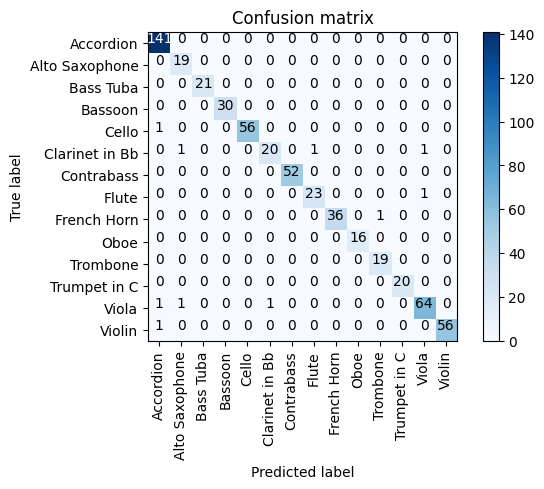

ACC =  0.9828
precision =  0.9796
recall =  0.9801 

Confusion matrix


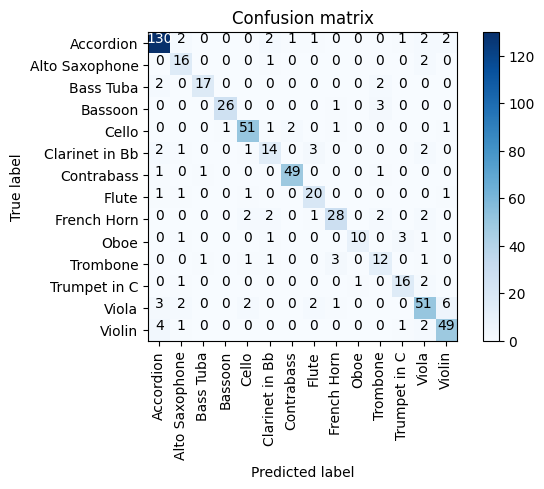

ACC =  0.8388
precision =  0.8082
recall =  0.7967 

Confusion matrix


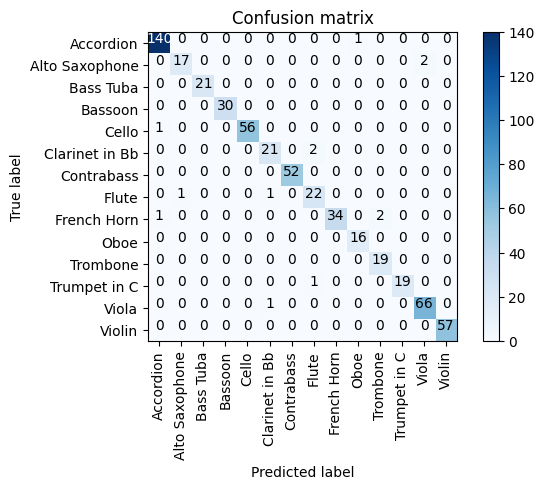

ACC =  0.9777
precision =  0.9671
recall =  0.9681 



In [25]:
# modify this to see the result of the other models (svm, dTree, mlp)
for i, evaluate_model in enumerate([svm_model, dt_model, mlp_model]):
    y_pred_instr = evaluate_model.predict(X_test)
    accuracy = accuracy_score(y_test_instrument, y_pred_instr)
    recall = recall_score(y_test_instrument, y_pred_instr, average='macro') #can try other ave method
    precision = precision_score(y_test_instrument, y_pred_instr, average='macro')

    cm = confusion_matrix(y_test_instrument, y_pred_instr)
    plot_confusion_matrix(cm , instr_classes)
    print('ACC = ',  round(accuracy,4))
    print('precision = ', round(precision,4))
    print('recall = ', round(recall, 4), '\n')

**Results from GridSearch (Question 3 Instrument Classification)**

*Due to number of runs, the scores below might not be the same with models provided(model1.pickle, model2.pickle, and model3.pickle.*

{'model': SVC(C=0.1, kernel='linear', random_state=42), 'val_score': 0.9725295718160054, 'test_score': 0.9828473413379074, 'best_params': {'C': 0.1, 'gamma': 'scale'}}

{'model': DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=5), 'val_score': 0.8278893806482389, 'test_score': 0.8421955403087479, 'best_params': {'criterion': 'log_loss', 'max_depth': 10}}

{'model': MLPClassifier(alpha=0.1, hidden_layer_sizes=(64,), max_iter=300), 'val_score': 0.981970909637011, 'test_score': 0.9897084048027445, 'best_params': {'alpha': 0.1, 'hidden_layer_sizes': (64,)}}

*  SVM -- ACC =  0.9828, precision =  0.9796, recall =  0.9801 
*  DecisionTree -- ACC =  0.8422, precision =  0.8188, recall =  0.8088 
*  MLP models -- ACC =  0.9897, precision =  0.987, recall =  0.9835 

The MLP model has the highest accuracy and precision because it is a deep learning model, capable of learning complex patterns and relationships in the data. The MLP model also has a regularization parameter alpha=0.1 that controls the degree of regularization, which helps to prevent overfitting. 

The SVM model has the second-best performance because it uses a linear kernel with C=0.1. A linear kernel is suitable for datasets where the decision boundary is linear and MFCCs are pretty much linear. C controls the trade-off between maximizing the margin and minimizing the classification error, in this case, C=0.1 may be appropriate for the given dataset.

The decision tree model has the lowest accuracy and precision because it has a relatively low maximum depth of 10, and the criterion is set to 'log_loss.' A maximum depth of 10 means that the tree can only have a maximum of 10 decision nodes, which may not be sufficient to capture the complexity of the given dataset. Moreover, using the 'log_loss' criterion for a decision tree classifier is not common and may not be appropriate for this dataset.

**Results from non Gridsearch (Question 3 Instrument Classification)**
*  SVC(kernel='linear', random_state=42)
Average validation score: 0.9725295718160054
Test score: 0.9794168096054888 

*  DecisionTreeClassifier(max_depth=12, min_samples_leaf=5)
Average validation score: 0.8042893488458378
Test score: 0.8319039451114922 

*  MLPClassifier(max_iter=300)
Average validation score: 0.9746795466391046
Test score: 0.9725557461406518 

# Question 4 Pitch Classification

Trained model are provided in the 'model' folder, and are named model1_pitch.pickle(svm), model2_pitch.pickle(dTree), model3_pitch.pickle(MLP)

model location:
https://drive.google.com/drive/folders/1gMT2aCMQA9S1OmgCXKZhrJl14iM512Qm?usp=sharing 

In [12]:
# Flatten so they can be trained by the model
X_train = np.reshape(X_pitch_train, (X_pitch_train.shape[0], -1))
X_test = np.reshape(X_pitch_test, (X_pitch_test.shape[0], -1))
# X_train[0].shape #400 length=25600

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# # Import scikit-learn library for models and K-fold cross-validation
# from sklearn.model_selection import KFold
# # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# from sklearn.svm import SVC
# # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# from sklearn.tree import DecisionTreeClassifier
# # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# from sklearn.neural_network import MLPClassifier

# # Create a model for Intstrument Classification
# svm = SVC(kernel='rbf', random_state=42) #best = rbf
# dTree = DecisionTreeClassifier(max_depth=20, min_samples_leaf=5) #best =20, 5
# mlp = MLPClassifier(max_iter=300, hidden_layer_sizes=(128,)) # 

# # loop through tree models:
# for idx, model in enumerate([svm]):
#     # Perform K-fold cross-validation 
#     print(model)
#     val_scores = []
#     kfold = KFold(n_splits=6)
#     for train_index, val_index in kfold.split(X_train):
#         X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
#         y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]

#         # TODO: Train your model using the train subset
#         model.fit(X_train_kfold, y_train_kfold_pitch)

#         # TODO:　Evaluate your model using the validation subset
#         score = model.score(X_val_kfold, y_val_kfold_pitch)
#         val_scores.append(score)
        
#     # Compute the average validation score across all folds
#     avg_val_score = sum(val_scores) / len(val_scores)
#     print("Average validation score:", avg_val_score)

#     # Evaluate your model using the test set
#     test_score = model.score(X_test, y_test_pitch)
#     print("Test score:", test_score,'\n')

#     filename = "./model"+str(idx+1)+".pickle"

#     # save model
#     pickle.dump(model, open(filename, "wb"))

from sklearn.model_selection import KFold, GridSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=6)
results = []

# Create models
svm_model = SVC(kernel='rbf', random_state=42) #best = rbf
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=5) #best =20, 5
mlp_model = MLPClassifier(max_iter=300) # 

# Set up GridSearchCV for each model
svm_param_grid = {'C': [0.1, 1, 2, 5], 'gamma': ['scale', 'auto']}
dt_param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [5,10,15,20,25]}
mlp_param_grid = {'hidden_layer_sizes': [(32,), (64,), (128,)], 'alpha': [0.001, 0.01, 0.1]}

svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=kf, scoring="accuracy", return_train_score=True)
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=kf, scoring="accuracy", return_train_score=True)
mlp_grid_search = GridSearchCV(estimator=mlp_model, param_grid=mlp_param_grid, cv=kf, scoring="accuracy", return_train_score=True)

# Train and evaluate models using GridSearchCV
for idx, model in enumerate([dt_grid_search]):
    model.fit(X_train, y_train_pitch)
    val_score = model.best_score_
    test_score = model.score(X_test, y_test_pitch)
    print(model.best_estimator_, '\nval_score:',  val_score, '\ntest_score:',  test_score, '\nbest_params:',  model.best_params_, '\n')
    filename = "./model"+str(2)+"_pitch.pickle"
    pickle.dump(model, open(filename, "wb"))

In [ ]:
svm_model = pickle.load(open("./model1_pitch.pickle", "rb"))
dt_model = pickle.load(open("./model2_pitch.pickle", "rb"))
mlp_model = pickle.load(open("./model3_pitch.pickle", "rb"))

In [ ]:
for evaluate_model in [svm_model, dt_model, mlp_model]:
    y_pred_pitch = evaluate_model.predict(X_test)

    accuracy = accuracy_score(y_test_pitch, y_pred_pitch)
    recall = recall_score(y_test_pitch, y_pred_pitch, average='macro') #can try other ave method
    precision = precision_score(y_test_pitch, y_pred_pitch, average='macro')

    print('ACC = ',  round(accuracy,4))
    print('precision = ', precision)
    print('recall = ', recall, '\n')

**Results from GridSearch (Question 4 Pitch Classification)**

*Due to number of runs, the scores below might not be the same with models provided(model1.picle, model2.pickle, and model3.pickle.*

*  SVC(C=5, gamma='auto', random_state=42) 
val_score: 0.7854221327043525 
test_score: 0.7958833619210978 
best_params: {'C': 5, 'gamma': 'auto'} 

*  DecisionTreeClassifier(max_depth=25, min_samples_leaf=5) 
val_score: 0.7137375330170762 
test_score: 0.7358490566037735 
best_params: {'criterion': 'gini', 'max_depth': 25} 
*  MLPClassifier(alpha=0.01, hidden_layer_sizes=(64,), max_iter=300) 
val_score: 0.8141657611816359 
test_score: 0.8662092624356775 
best_params: {'alpha': 0.01, 'hidden_layer_sizes': (64,)} 

Comparing the results of the three models, we can see that the MLP model performed the best in terms of accuracy, precision, and recall on both validation and test sets. The SVM model performed well, but slightly lower than the MLP model. The Decision Tree model achieved the lowest accuracy and precision scores and the lowest recall score on the test set.

The choice of hyperparameters can greatly affect the performance of the models. For example, in the SVM model, a higher value of C can lead to a more complex decision boundary and better training accuracy, but it can also cause overfitting on the training set. On the other hand, a lower value of C can lead to a simpler decision boundary, lower training accuracy, and better generalization on the test set.

In the MLP model, the alpha parameter controls the regularization strength, and a lower value of alpha can lead to overfitting, while a higher value can lead to underfitting. The choice of the number of hidden layers and neurons in each layer can also affect the performance of the model, with a larger number of layers and neurons leading to a more complex model, and potentially better performance on the training set, but also a higher risk of overfitting.

**Results from non GridSearch (Question 4 Pitch Classification)**

melspectrogram features:

*  SVC(random_state=42)
Average validation score: 0.7244752603821589
Test score: 0.7495711835334476 

*  DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)
Average validation score: 0.6845544130248501
Test score: 0.7135506003430532 

*  MLPClassifier(max_iter=300)
Average validation score: 0.015456187775510383
Test score: 0.017152658662092625

Chroma stft features:

*  SVC(rbf, random_state=42)
Average validation score: 0.5841195593600651
Test score: 0.6295025728987993 

*  DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)
Average validation score: 0.5793977861995248
Test score: 0.5951972555746141 

*  MLPClassifier(max_iter=300)
Average validation score: 0.7334958789388599
Test score: 0.7770154373927959 

FROM the results above, we can see that SVC and decision tree perform better with the mel-spectrogram features, while MLP perform better with the chroma features. In fact, I have also tried MFCCs with pitch classification, but the result is disappointing.

Regardless, I have tried to scale the input data using StandardScaler or MinMaxScaler before training. The result is satisfying, although there are not much differnce in SVC and decisionTree, but MLP model does imporved a lot.

*  SVC(random_state=42)
Average validation score: 0.7163258951050805
Test score: 0.7444253859348199 

*  DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)
Average validation score: 0.6841215470101326
Test score: 0.7152658662092625 

*  MLPClassifier(hidden_layer_sizes=(128,), max_iter=300)
Average validation score: 0.8038697338315708
Test score: 0.8319039451114922 